In [3]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

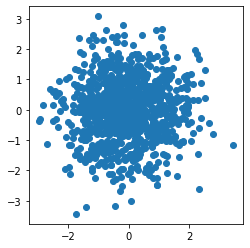

In [116]:
# independent Gaussians
# d : dimension of Gaussian
# rho : correlation between different coordinates
# n : total number of samples we want to draw
def sample_gaussian(d, rho, n=1000):
    cov = rho * np.ones(shape=(d,d)) + (1-rho) * np.eye(d) # d = 3 -> [1 rho rho; rho 1 rho ; rho rho 1]
    return st.multivariate_normal(cov=cov).rvs(size=n)

samples = sample_gaussian(10, 0.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])


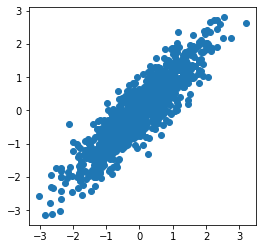

In [121]:
samples = sample_gaussian(10, 0.9)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])


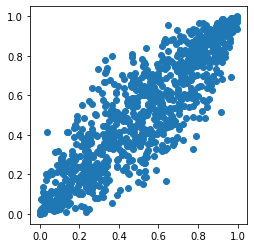

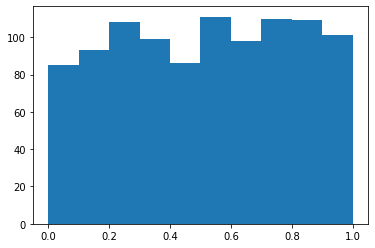

In [124]:
# Suppose v ~ Normal(0, 1)
# Phi is the CDF of Normal
# Phi(v) is Uniform(0,1)
# P[Phi(v) < t] = t for all t in [0, 1]
# P[v < x] = Phi(x)
# P[Phi(v) < t] = Phi(Phi^(-1)(t))) = t
def uniform_copula(gaussian_samples):
    return st.norm.cdf(gaussian_samples)

samples = uniform_copula(sample_gaussian(2, 0.9, n=1000))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])
plt.show()
plt.clf()
plt.hist(samples[:,0])
plt.show()

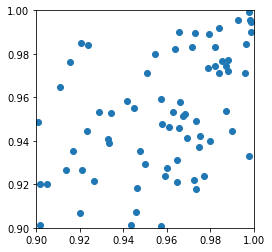

Correlation across entire sample:
[[1.         0.88835637]
 [0.88835637 1.        ]]
Correlation across entire sample:
[[1.         0.46951524]
 [0.46951524 1.        ]]


In [127]:
threshold = 0.9
indices = (samples[:, 0] > threshold) & (samples[:, 1] > threshold)
plt.scatter(samples[indices,0], samples[indices, 1])
plt.xlim(threshold, 1.0)
plt.ylim(threshold, 1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
print('Correlation across entire sample:')
print(np.corrcoef(samples[:,0], samples[:,1]))
print('Correlation across entire sample:')
print(np.corrcoef(samples[indices,0], samples[indices,1]))

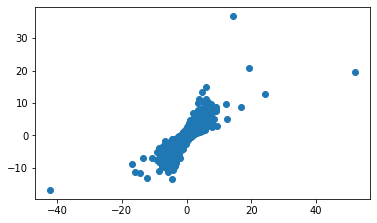

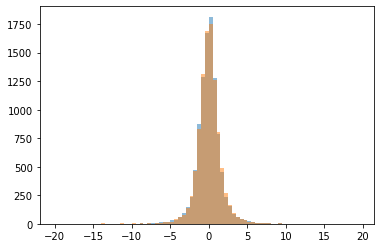

Correlation across entire sample:
[[1.         0.85700456]
 [0.85700456 1.        ]]
Correlation across tail:
[[1.        0.6868707]
 [0.6868707 1.       ]]


In [131]:
# Gaussian -> Uniform : apply CDF of Gaussian
# now have uniform samples, want to go to target_dist
# Uniform -> target_dist : apply inverse CDF of target_dist
def copula(gaussian_samples, target_dist):
    percentiles = uniform_copula(gaussian_samples)
    tail = np.max(percentiles, axis=1)
    # in scipy.stats, ppf is the name of the function that computes the inverse CDF
    return target_dist.ppf(percentiles), tail

n=10000
dist = st.t(3)
samples, tail = copula(sample_gaussian(2, 0.9, n), dist)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])
plt.show()
plt.clf()
plt.hist(samples[:,0], bins=np.arange(-20, 20, 0.5), alpha=0.5)
plt.hist(dist.rvs(size=n), bins=np.arange(-20, 20, 0.5), alpha=0.5)
plt.show()
print('Correlation across entire sample:')
print(np.corrcoef(samples[:,0], samples[:,1]))
print('Correlation across tail:')
indices = tail > 0.8
print(np.corrcoef(samples[indices,0], samples[indices,1]))

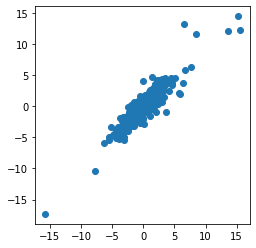

In [132]:
def sample_t(d, rho, df=3, n=1000):
    cov = rho * np.ones(shape=(d,d)) + (1-rho) * np.eye(d)
    scale = np.sqrt(df / st.chi2(df).rvs(n))
    return st.multivariate_normal(cov=cov).rvs(size=n) * np.reshape(scale, (n, 1))

samples = sample_t(10, 0.9)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])

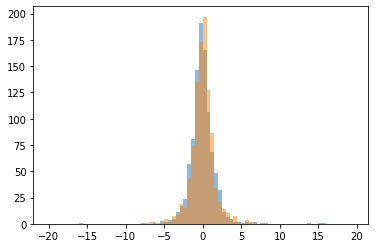

In [133]:
plt.hist(samples[:,0], bins=np.arange(-20, 20, 0.5), alpha=0.5)
plt.hist(st.t(3).rvs(size=1000), bins=np.arange(-20, 20, 0.5), alpha=0.5)
plt.show()

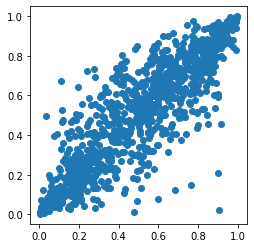

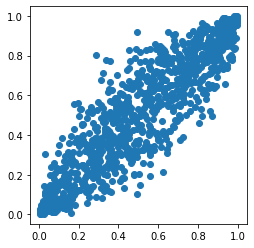

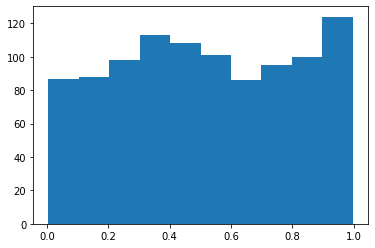

In [139]:
# before we applied Normal CDF to get to uniform distribution
# now, we instead want to apply the CDF of a student-t distribution
def uniform_t_copula(t_samples, df=3):
    return st.t(df).cdf(t_samples)

samples = uniform_t_copula(sample_t(2, 0.9))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0], samples[:, 1])
plt.show()
# plt.clf()
# plt.hist(samples[:,0])
# plt.show()

old_samples = uniform_copula(sample_gaussian(2, 0.9))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(old_samples[:,0], old_samples[:, 1])
plt.show()
plt.clf()
plt.hist(old_samples[:,0])
plt.show()

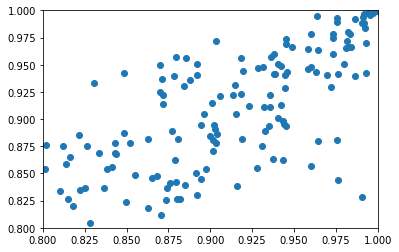

Correlation across entire sample:
[[1.         0.87642194]
 [0.87642194 1.        ]]
Correlation across the tail:
[[1.        0.6830035]
 [0.6830035 1.       ]]


In [140]:
threshold = 0.8
indices = (samples[:, 0] > threshold) & (samples[:, 1] > threshold)
plt.scatter(samples[indices,0], samples[indices, 1])
plt.xlim(threshold, 1.0)
plt.ylim(threshold, 1.0)
plt.show()
print('Correlation across entire sample:')
print(np.corrcoef(samples[:,0], samples[:,1]))
print('Correlation across the tail:')
print(np.corrcoef(samples[indices,0], samples[indices,1]))

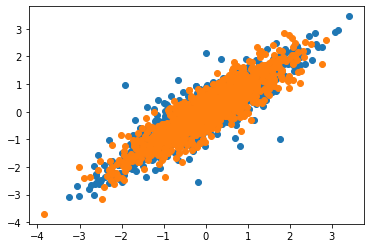

In [141]:
# apply same idea as before:
# Uniform -> target_dist by applying inverse cdf of target_dist
def copula_t(t_samples, target_dist, df=3):
    percentiles = uniform_t_copula(t_samples, df)
    tail = np.max(percentiles, axis=1)
    return target_dist.ppf(percentiles), tail

samples, tail = copula_t(sample_t(2, 0.9), st.norm())
samples2, tail2 = copula(sample_gaussian(2, 0.9), st.norm())
plt.scatter(samples[:, 0], samples[:, 1])
plt.scatter(samples2[:, 0], samples2[:, 1])

1.3837542827976919
1.5187903928104203


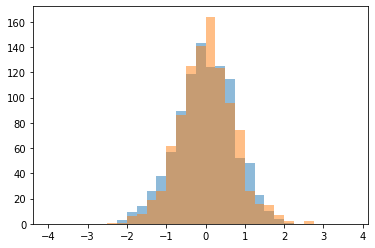

In [147]:
# Now look at sum of lots of variables
# 1000 mortgages (d = 1000)
# Have some financial instrument whose value is the average value of all the mortgages
# Simple (probably wrong) assumption: each mortgage value is normal distributed
d=1000
samples_gaussian, _ = copula(sample_gaussian(d, 0.5), st.norm())
samples_t, _ = copula_t(sample_t(d, 0.5), st.norm())
samples_gaussian = np.sum(samples_gaussian, axis=1) / d
samples_t = np.sum(samples_t, axis=1) / d
plt.hist(samples_gaussian, bins=np.arange(-4,4,.25), alpha=0.5)
plt.hist(samples_t, bins=np.arange(-4,4,.25), alpha=0.5)
print(np.quantile(samples_gaussian, 0.975))
print(np.quantile(samples_t, 0.975))

1.0
1.0


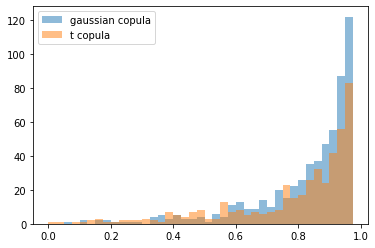

In [150]:
# Now look at sum of lots of variables
# Better model: Bernoulli distribution -> some probability of default (value = 0), 
# otherwise get back full cost of mortgage
d=1000
samples_gaussian, _ = copula(sample_gaussian(d, 0.5), st.bernoulli(0.9))
samples_t, _ = copula_t(sample_t(d, 0.5), st.bernoulli(0.9))
samples_gaussian = np.sum(samples_gaussian, axis=1) / d
samples_t = np.sum(samples_t, axis=1) / d
plt.hist(samples_gaussian, bins=np.arange(0,1,.025),alpha=0.5, label='gaussian copula')
plt.hist(samples_t, bins=np.arange(0,1,.025),alpha=0.5,  label='t copula')
plt.legend()
print(np.quantile(samples_gaussian, 0.975))
print(np.quantile(samples_t, 0.975))